# Paper experiments

### 1. **Table 2 and 3**: Accuracy and training time tables comparing MICAT performances with competitors 

"MICAT" framework is refered as "GAP" in the code, and 'Naive-CAT' as Adam. The first cell set the configuration. **Hyperparameters** must be adapted as indicated, depending on the combination of (Dataset, CDM, Competitor), according to the values contained in file : **'MICAT/experiments/data/CAT_hyperparameters.csv'**, **'MICAT/experiments/data/CDM_hyperparameters.csv'**

### 1.0. Configuration : Choose your combination (Dataset, CDM, Adaptation method), and set the corresponding parameters

In [1]:
import micat
config = micat.utils.generate_eval_config(
    #### Change the following values: ####

    ### Dataset name :
    dataset_name="assist0910",  # ['assist0910', 'math2', 'algebra']
    n_query=16, #{'assist0910':16, 'math2':16, 'algebra':25}

    ### CDM: 
    CDM = 'impact', # ['impact','ncdm']
    lambda_=7.380681029927064e-05,
    learning_rate = 0.001,

    ### Competitor:     
    meta_trainer='GAP', #['Adam', 'Approx_GAP','MAML','GAP', 'BETA-CD']
    num_inner_users_epochs=3,
    inner_user_lr= 0.0007838402204978467,
    meta_lr=0.05,

    #### Fixed hyperpameters ####
    load_params=True,
    
    save_params=False,
    esc = 'error',
    batch_size = 512,
    valid_batch_size = 10000,
    num_epochs=100,
    eval_freq = 1,
    patience = 20,
    pred_metrics = ["mi_acc","rmse","mae","mi_prec","mi_rec","mi_f_b","mi_auc","ma_prec","ma_rec","ma_f_b"],
    profile_metrics = ['meta_doa','pc-er','rm'],
    valid_metric= 'rmse',
)

#### Extra method-specific hyperparameters : 

## BETA-CD
config['kl_weight'] =0.0005

## MICAT (GAP)
config['learning_users_emb_lr'] = 0.0001

CUDA is available. Using GPU.


### 1.1. Launch script (to run only)

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["PYTHONHASHSEED"] = "0"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

import micat
micat.utils.set_seed(0)
from micat.dataset import preprocessing_utilities as pu

import logging
import gc
import json
import torch
import pandas as pd
import argparse
import time 

print("PID", os.getpid(), "sees CUDA_VISIBLE_DEVICES =", os.environ.get("CUDA_VISIBLE_DEVICES"))
if os.environ.get("CUDA_VISIBLE_DEVICES") is not None:
    print("→ torch.device is", torch.cuda.current_device(), torch.cuda.get_device_name(0))
    
logging.info(f'#### config : {config} ####')

concept_map = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'
))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

metadata = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'
))

nb_modalities = torch.load(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_nb_modalities.pkl',
    weights_only=True
)

for i_fold in range(5):
    train_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
        encoding='utf-8',
        dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
    )
    valid_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
        encoding='utf-8',
        dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
    )
    test_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
        encoding='utf-8',
        dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
    )

    train_data = micat.dataset.CATDataset(train_df, concept_map, metadata, config, nb_modalities)
    valid_data = micat.dataset.EvalDataset(valid_df, concept_map, metadata, config, nb_modalities)
    test_data  = micat.dataset.EvalDataset(test_df,  concept_map, metadata, config, nb_modalities)

    S = micat.selectionStrategy.Random(train_data.metadata, **config)
    S.init_models(train_data, valid_data)

    # — Training time measurement
    logging.info("⏳ Training started...")
    t_start = time.time()
    S.train(train_data, valid_data)
    t_end = time.time()
    logging.info(f"✅ Training completed in {t_end - t_start:.2f} seconds.")

    S.reset_rng()
    d = S.evaluate_test(test_data, train_data, valid_data)
    logging.info(f"Fold {config['i_fold']}; results: {d}")

    del S
    gc.collect()
    torch.cuda.empty_cache()

### 2. **Figure 2**: Critical Difference Diagram ranking MICAT performances and interpretability with competitors

Generate latex of the diagram in 'MICAT/experiments/data/critical_diff.tex'

### (to run only)

In [8]:
#!/usr/bin/env python3
import numpy as np
import json
import glob
import re
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
algorithms = ["Adam", "MAML", "Approx_GAP", "Beta_cd", "MICAT"]
datasets = ["algebra", "assist0910", "math2"]
subalgos = ["IMPACT", "NCDM"]
metrics = ["mi_acc","rmse","mae","mi_prec","mi_rec","mi_f_b","mi_auc","ma_prec","ma_rec","ma_f_b",'meta_doa','pc-er','rm']
pattern = re.compile(
    r"^CAT_launch_"
    r"(?P<dataset>.+?)_"
    r"(?P<subalgo>.+?)_"
    r"(?P<algorithm>.+?)_"
    r"\d+_all_results\.json$"
)

output_dir = "cd_plots"
os.makedirs(output_dir, exist_ok=True)

# Collect metric values across all valid datasets/subalgos/folds/steps
results = {m: {a: [] for a in algorithms} for m in metrics}
files = glob.glob("../scripts/results_curves/CAT_launch_*_IMPACT_*_all_results.json") + \
        glob.glob("../scripts/results_curves/CAT_launch_*_NCDM_*_all_results.json")
print(f"[INFO] Found {len(files)} candidate result files.")

for file in files:
    m = pattern.match(os.path.basename(file))
    if not m:
        print(f"[WARN] Filename does not match expected pattern: {file}")
        continue
    ds, subalgo, algo = m["dataset"], m["subalgo"], m["algorithm"]
    if ds not in datasets or algo not in algorithms:
        print(f"[WARN] Skipping file due to unmatched dataset/algo: {ds}, {algo}")
        continue
    if ds=="algebra" and subalgo=="NCDM":
        continue
    try:
        with open(file, "r") as f:
            folds = json.load(f)
        for fold_idx, (pred, meta) in enumerate(folds):
            value_acc = {metric:0 for metric in metrics}
            for step in pred:
                for metric in metrics:
                    value = pred[step].get(metric)
                    if value is None or np.isnan(value):
                        value = meta[step].get(metric)
                    if value is not None and not np.isnan(value):
                        value_acc[metric] += value 
            for metric in metrics :
                results[metric][algo].append(value_acc[metric])
    except Exception as e:
        print(f"[ERROR] Failed to process {file}: {e}")

from critdd import Diagrams # Diagrams is the 2D version of Diagram
import numpy as np


# construct a sequence of CD diagrams
treatment_names = ["Naïve", "MAML", "Approx-GAP", "BETA-CD", "MICAT"]
metrics = ["mi_acc","mi_prec","mi_rec","mi_f_b","mi_auc",'meta_doa']
diagram_names = ["Accuracy","Precision","Recall","F1","AUC",'Meta Doa']
Xs = [] # collect an (n,k)-shaped matrix for each diagram
for n in metrics:
    Xs.append(np.array([results[n][algo] for algo in algorithms]).T)

two_dimensional_diagram = Diagrams(
    np.stack(Xs),
    diagram_names = diagram_names,
    treatment_names = treatment_names,
    maximize_outcome = True
)

two_dimensional_diagram.to_file(
    "../data/critical_diff.tex",
    alpha = .05,
    adjustment = "holm",
    reverse_x = True,
    axis_options = {"title": ""},
)
print("Critical difference diagram saved to ../data/critical_diff.tex")

[INFO] Found 28 candidate result files.
Critical difference diagram saved to ../data/critical_diff.tex


### 3. **Figure 3**: Visualization of student proficiency estimate during Meta-testing procedure with MICAT and CD-BPR

In [1]:
%load_ext autoreload
%autoreload 2

In [117]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["PYTHONHASHSEED"] = "0"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

import micat
import logging
import gc
import json
import torch
import pandas as pd
from micat.dataset import preprocessing_utilities as pu
import argparse
import warnings
import time  # ← Added to measure time

dataset_name = "math2"
cdm="impact"
i_fold=3

gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

config = micat.utils.generate_eval_config(
    CDM=cdm,
    dataset_name=dataset_name,
    i_fold = i_fold,
    load_params=True,
    save_params=False,
    esc = 'error',
    learning_rate = 0.001,
    batch_size = 512,
    valid_batch_size = 10000,
    num_epochs=100,
    eval_freq = 1,
    patience = 20,
    device = device,
    pred_metrics = ["mi_acc","rmse","mae","mi_prec","mi_rec","mi_f_b","mi_auc","ma_prec","ma_rec","ma_f_b"],
    profile_metrics = ['meta_doa','pc-er','rm'],
    meta_trainer='GAP',
    valid_metric= 'rmse',
    n_query=16,
    num_inner_users_epochs=3,
    lambda_=2.6180638633142202e-05,
    inner_user_lr=0.0030952659036283066,
    meta_lr=0.01
)
config['learning_users_emb_lr'] = 0.001
logging.info(f'#### config : {config} ####')

concept_map = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'
))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

metadata = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'
))

nb_modalities = torch.load(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_nb_modalities.pkl',
    weights_only=True
)

train_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)
valid_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)
test_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)

train_data = micat.dataset.CATDataset(train_df, concept_map, metadata, config, nb_modalities)
valid_data = micat.dataset.EvalDataset(valid_df, concept_map, metadata, config, nb_modalities)
test_data  = micat.dataset.EvalDataset(test_df,  concept_map, metadata, config, nb_modalities)

S = micat.selectionStrategy.Random(train_data.metadata, **config)
S.init_models(train_data, valid_data)

test_emb = torch.load(f'../data/evolving_emb_tensor_MICAT_{i_fold}.pt',weights_only=True).cpu()
train_emb = torch.load(f'../data/train_emb_tensor_MICAT_{i_fold}.pt',weights_only=False).weight.cpu()
q_ids=torch.load(f'../data/_sub_question_ids_MICAT_3.pt').cpu()
u_ids=torch.load(f'../data/_sub_user_ids_MICAT_3.pt').cpu()
l_ids=torch.load(f'../data/_sub_labels_MICAT_3.pt').cpu()
#c_ids=torch.load(f'../data/_sub_categories_MICAT_3.pt').cpu()

train_users_ids = torch.Tensor(list(train_data.users_id)).long()
train_emb = train_emb[train_users_ids]


In [98]:
t2_emb = test_emb[:,test_emb.var(dim=0)!=0].reshape(16,-1,16)

/lustre/fshomisc/sup/hpe/pub/miniforge/24.11.3/envs/pytorch-gpu-2.8.0+py3.12.11/lib/python3.12/site-packages/matplotlib/colors.py:2243: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/lustre/fshomisc/sup/hpe/pub/miniforge/24.11.3/envs/pytorch-gpu-2.8.0+py3.12.11/lib/python3.12/site-packages/matplotlib/colors.py:2250: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


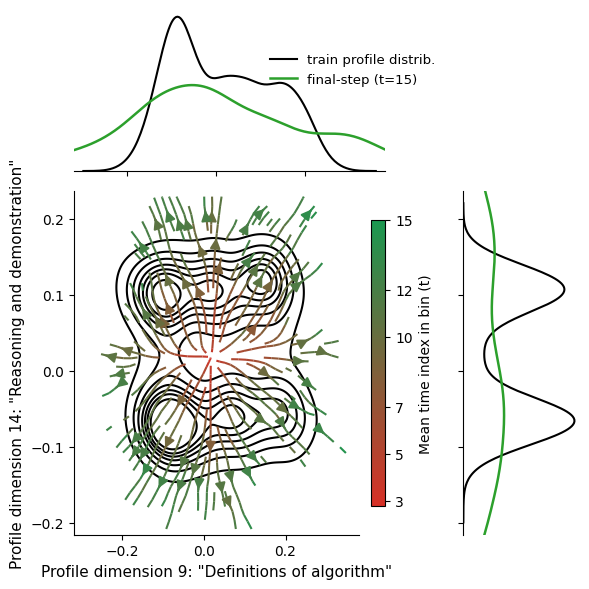

In [122]:
from micat.dataset import preprocessing_utilities as pu
pu.plot_embedding_distribution_flow(8,13,train_emb.detach().cpu().numpy(),t2_emb)

In [ ]:
U = torch.arange(test_emb.shape[0]).unsqueeze(0)
t= c_ids[u_ids==U]
U[t==i]

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w = v[test_data.df['dimension_id'] == 0]


Student 1600 : Category 2: 3/100, Category 13: 5/100
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 2, 2])
tensor([ 3,  3,  3, 14, 14, 14,  4,  4,  4,  4,  9,  9,  9,  0,  0,  0, 10, 10,
        10, 10,  2,  2,  2,  2,  6,  6,  6, 15, 15, 15,  5,  5,  5,  5, 12, 12,
         8,  8,  8,  8, 17, 17, 17, 17, 17,  1,  1, 11, 11, 11, 11, 13, 13])


/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:216: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


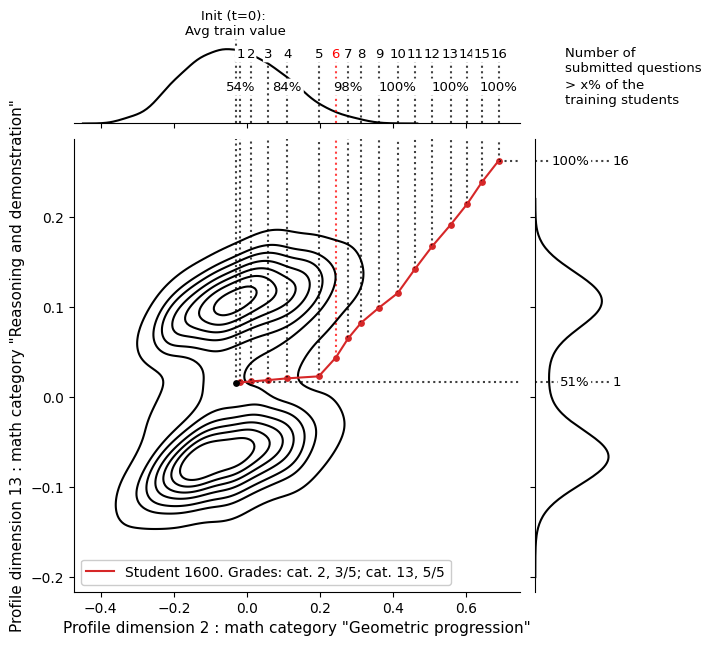

In [185]:
pu.plot_embedding_distribution(2,13,train_emb.detach().cpu().numpy(),test_emb, test_data=test_data, train_emb=train_emb, q_ids=q_ids, u_ids=u_ids,l_ids=l_ids)

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


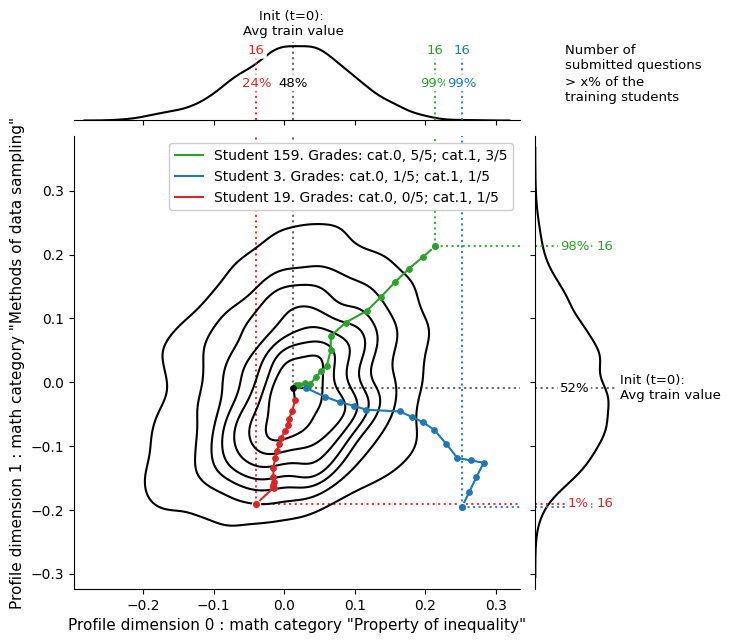

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


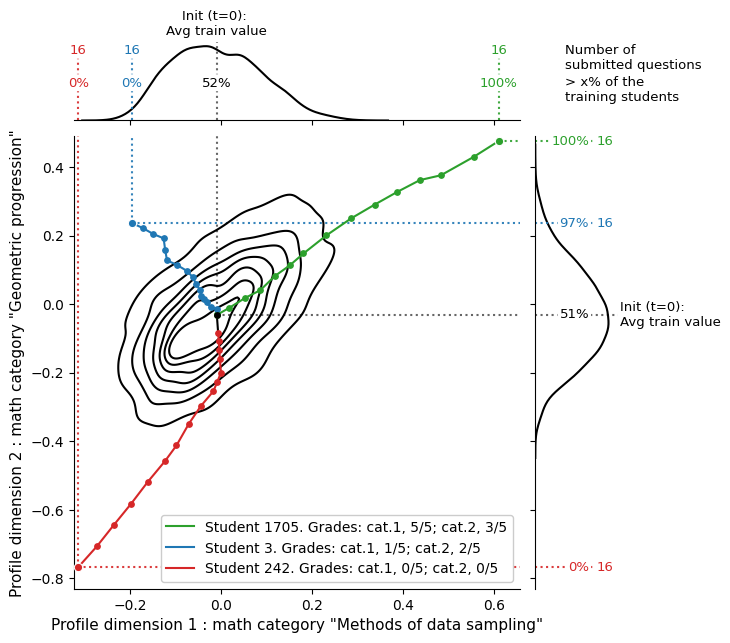

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


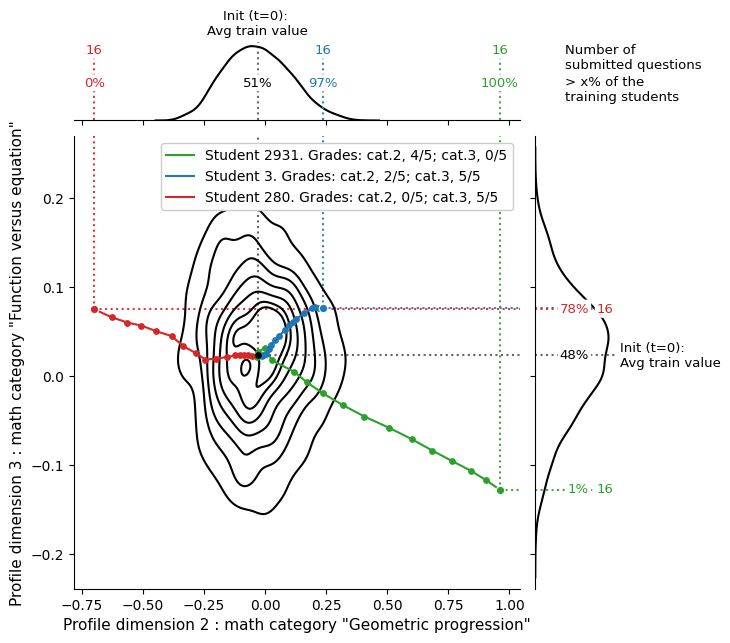

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


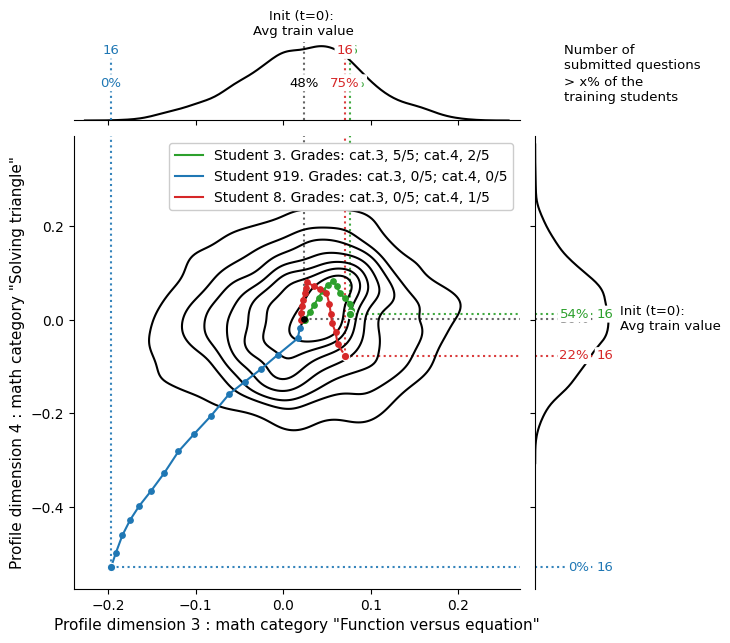

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


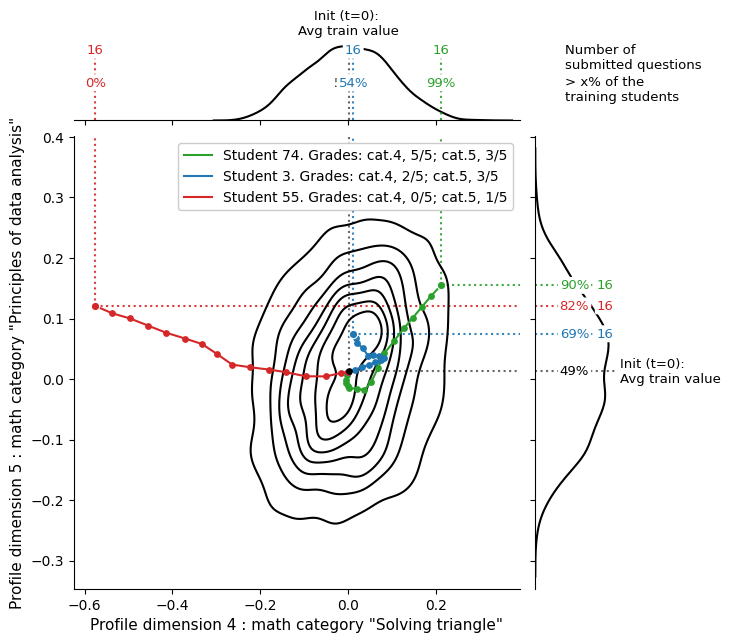

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


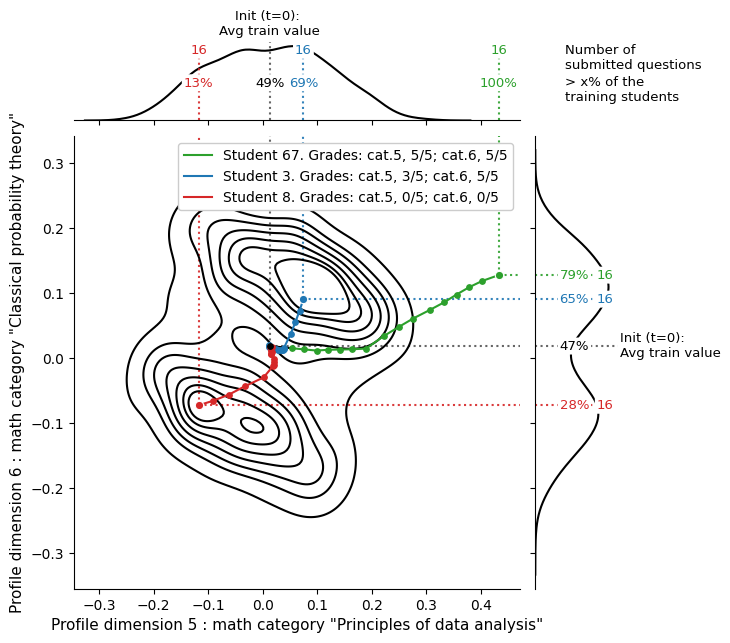

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


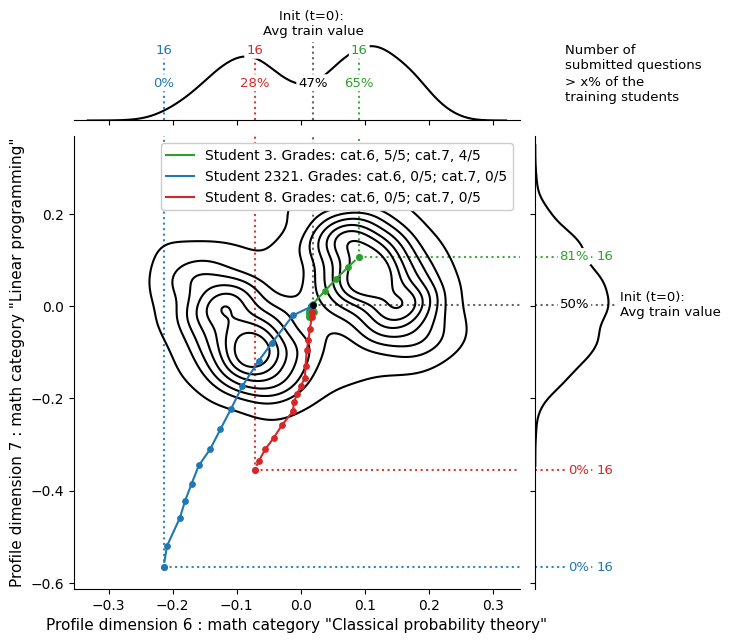

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


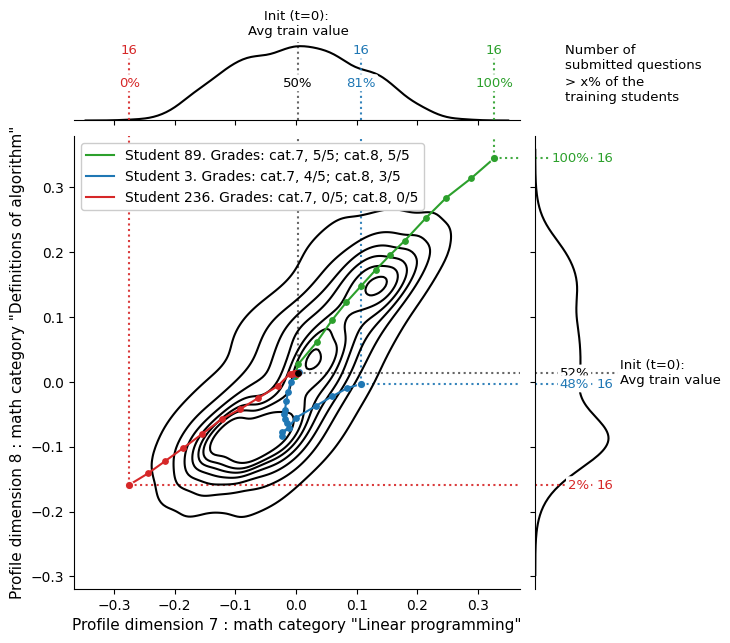

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


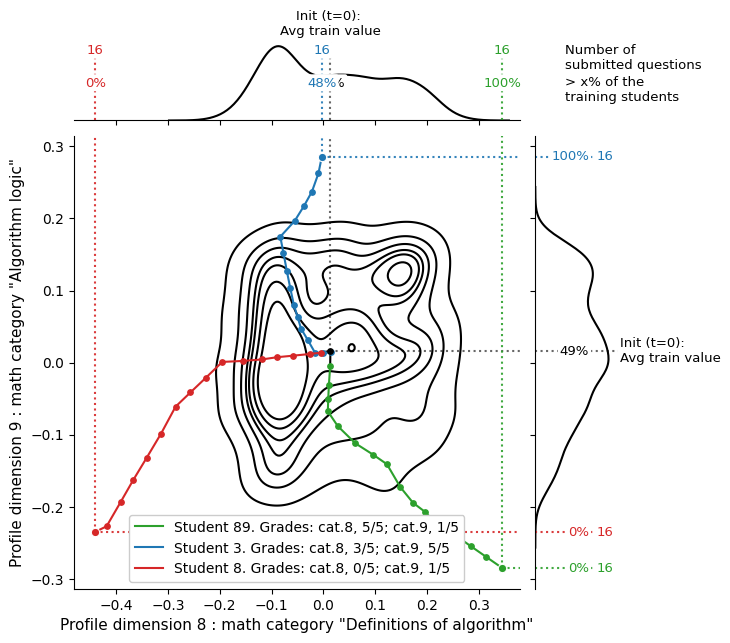

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


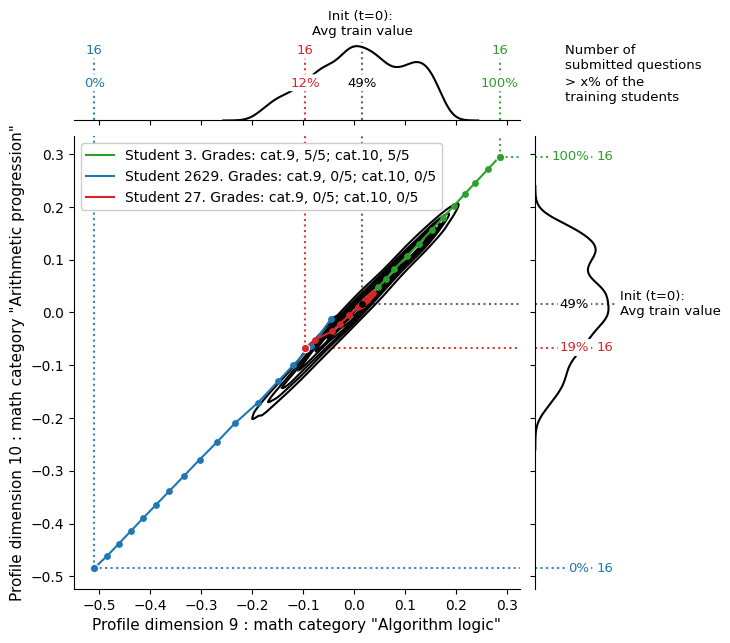

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


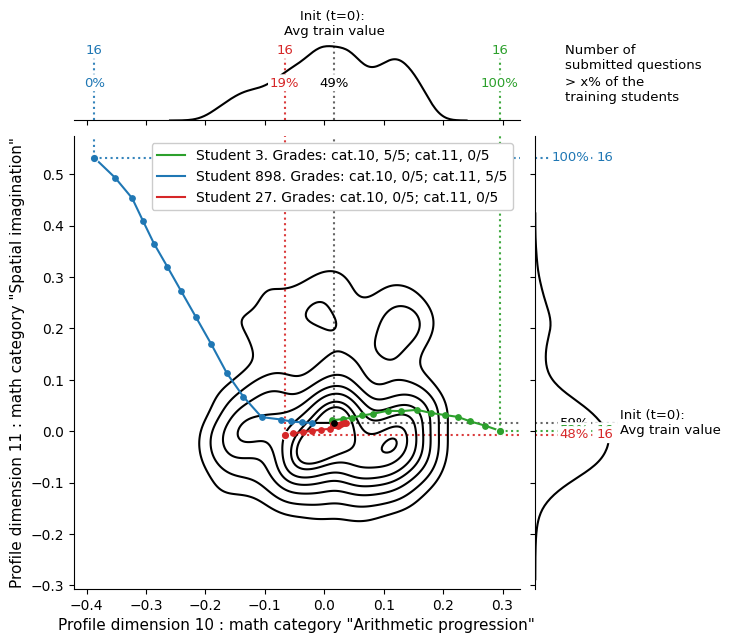

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


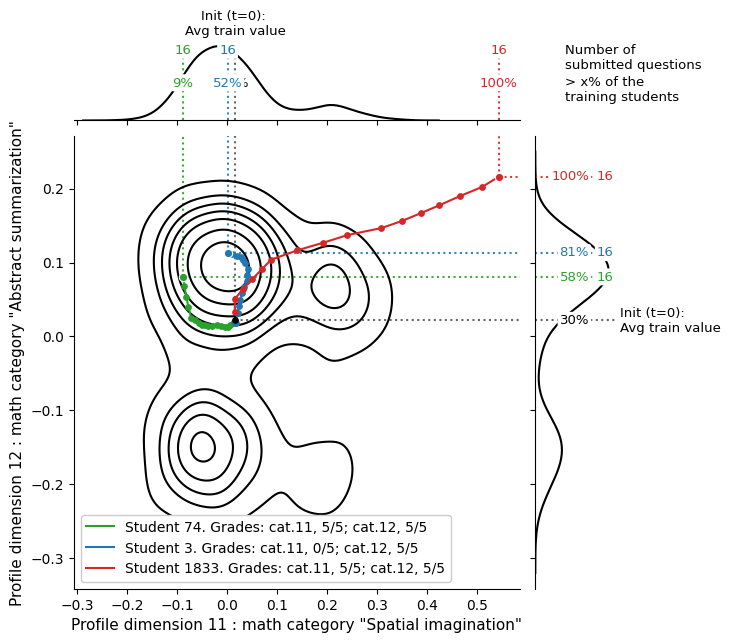

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


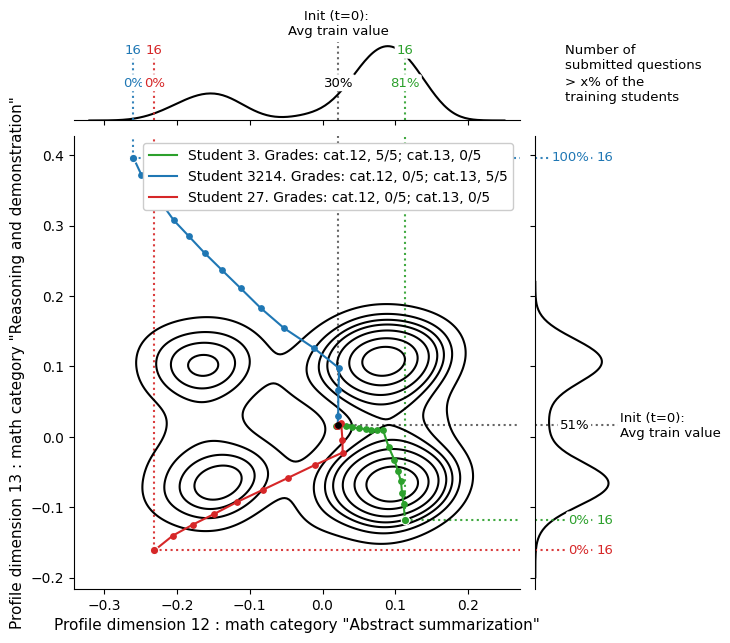

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


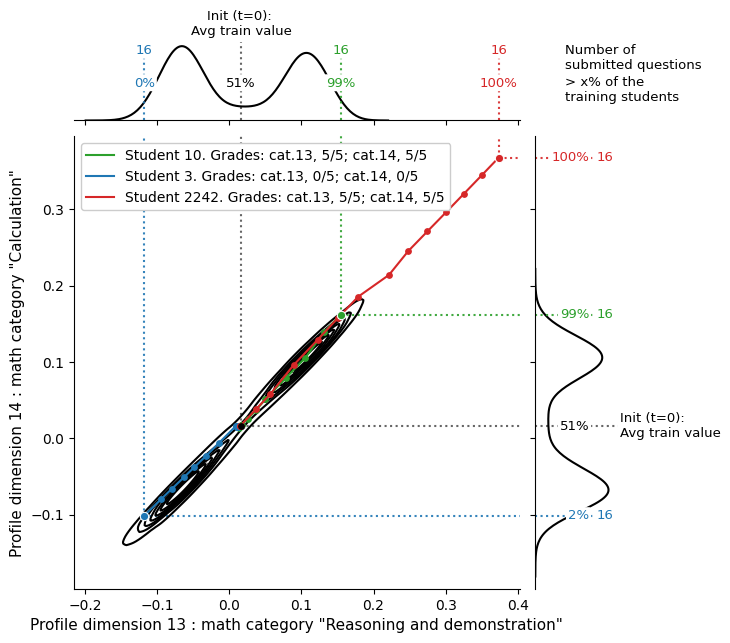

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:643: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


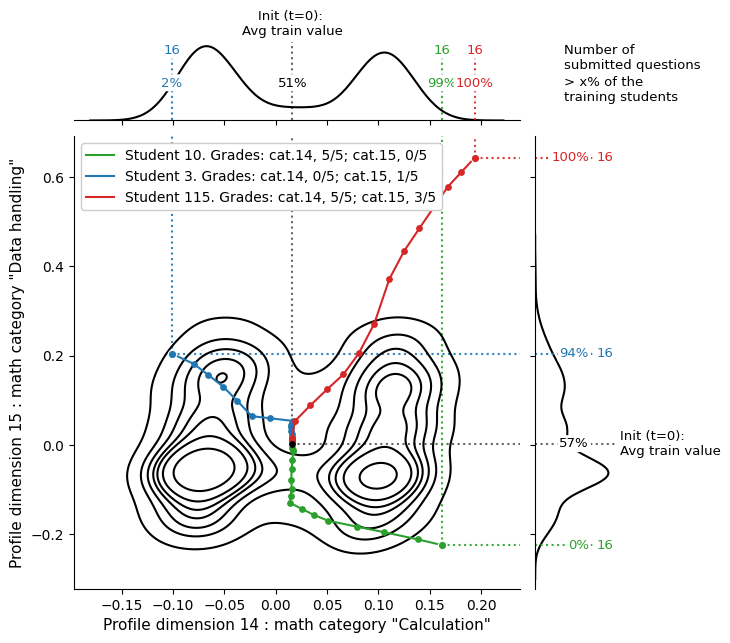

In [156]:
for i in range(15) : 
    pu.plot_embedding_distribution_comp(i,i+1,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data,train_emb=train_emb)

### 4. **Figure 4**: Accuracy across ablation study variants of MICAT

Loaded methods: ['MICAT_REG', 'MICAT_INIT_TERM', 'MICAT_TERM', 'MICAT_TERM_REG', 'MICAT', 'MICAT_INIT_REG', 'MICAT_INIT']


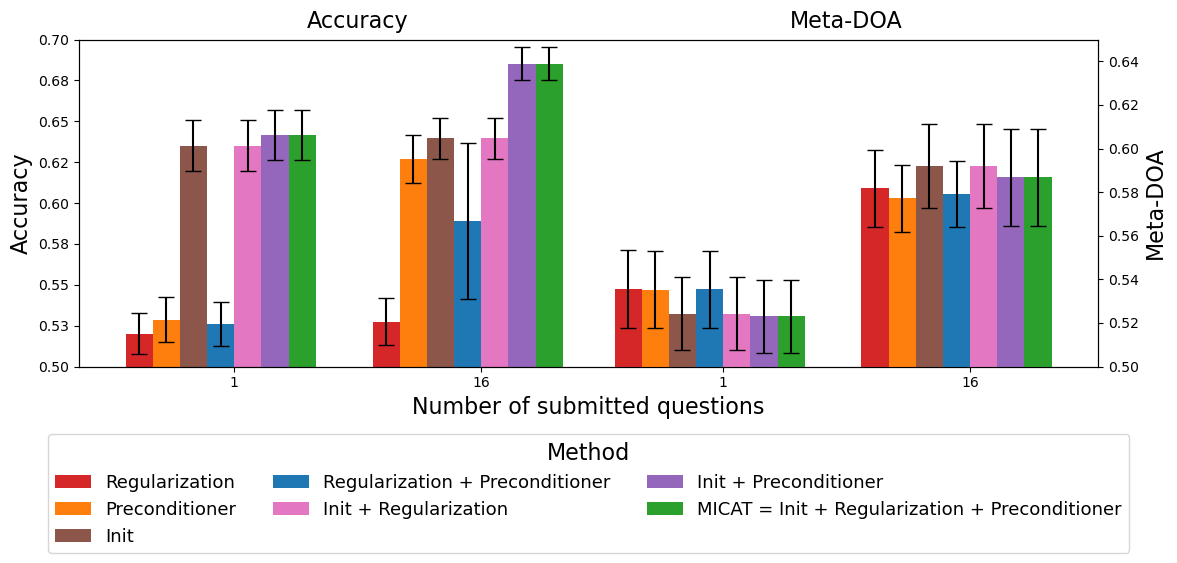

In [12]:
import glob
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
# Pattern to extract the method name between IMPACT_ and _all_results.json
method_pattern = re.compile(r'IMPACT_([A-Za-z0-9_]+)_\d+_all_results\.json')

results = {}

# Find all relevant files in the current directory
for file in glob.glob("../scripts/results_ablation2_assist0910/CAT_launch_*_IMPACT_*_all_results.json"):
    filename = os.path.basename(file)
    match = method_pattern.search(filename)
    if match:
        method = match.group(1)
        # Load the JSON data
        with open(file, "r") as f:
            data = json.load(f)
        results[method] = data
    else:
        print(f"Filename did not match pattern: {filename}")

# Now 'results' is a dictionary mapping each method name to its loaded data
print("Loaded methods:", list(results.keys()))

# === Data computations (unchanged) ===
r1 = {m : {step:[] for step in range(16)} for m in results.keys()}
std_acc = {m : {step:0 for step in range(16)} for m in results.keys()}
mean_acc = {m : {step:0 for step in range(16)} for m in results.keys()}
for method in results.keys():
    for i_fold, fold in enumerate(results[method]) : 
        for step, values in fold[0].items() :
            r1[method][int(step)].append(values['mi_acc'])
for method in results.keys():
    for step, values in fold[0].items() :
            std_acc[method][int(step)] = (np.array(r1[method][int(step)])).std()
            mean_acc[method][int(step)] = (np.array(r1[method][int(step)])).mean()

r1 = {m : {step:[] for step in range(16)} for m in results.keys()}
std_doa = {m : {step:0 for step in range(16)} for m in results.keys()}
mean_doa = {m : {step:0 for step in range(16)} for m in results.keys()}
for method in results.keys():
    for i_fold, fold in enumerate(results[method]) : 
        for step, values in fold[1].items() :
            r1[method][int(step)].append(values['meta_doa'])
for method in results.keys():
    for step, values in fold[1].items() :
            std_doa[method][int(step)] = (np.array(r1[method][int(step)])).std()
            mean_doa[method][int(step)] = (np.array(r1[method][int(step)])).mean()

# === Plotting with separated groups and big titles ===
indices = [0, 15]
methods = ['MICAT_REG', 'MICAT_TERM','MICAT_INIT', 'MICAT_TERM_REG', 
           'MICAT_INIT_REG', 'MICAT_INIT_TERM','MICAT']
colors = {
    'MICAT_INIT': 'tab:brown',
    'MICAT_INIT_REG': 'tab:pink',
    'MICAT': 'tab:green',
    'MICAT_INIT_TERM': 'tab:purple',
    'MICAT_REG': 'tab:red',
    'MICAT_TERM': 'tab:orange',
    'MICAT_TERM_REG': 'tab:blue'
}
labels = {
    'MICAT_INIT': 'Init',
    'MICAT_INIT_REG': 'Init + Regularization',
    'MICAT': 'MICAT = Init + Regularization + Preconditioner',
    'MICAT_INIT_TERM': 'Init + Preconditioner',
    'MICAT_REG': 'Regularization',
    'MICAT_TERM': 'Preconditioner',
    'MICAT_TERM_REG': 'Regularization + Preconditioner'
}

# Extract means and stds
means_acc = np.array([[mean_acc[m][idx] for m in methods] for idx in indices])
stds_acc  = np.array([[std_acc[m][idx]  for m in methods] for idx in indices])
means_doa = np.array([[mean_doa[m][idx] for m in methods] for idx in indices])
stds_doa  = np.array([[std_doa[m][idx]  for m in methods] for idx in indices])

n_methods = len(methods)
n_groups  = len(indices)
bar_w     = 0.11

# x positions for each cluster
x_acc = np.arange(n_groups)
cluster_width = n_methods * bar_w
gap = cluster_width + bar_w +1.1
x_doa = x_acc + gap

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
from matplotlib.ticker import FuncFormatter

ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Plot Accuracy bars on left axis
for i, m in enumerate(methods):
    ax1.bar(x_acc + i*bar_w,
            means_acc[:, i],
            width=bar_w,
            yerr=stds_acc[:, i],
            capsize=6,
            label=labels[m],
            color=colors[m])

# Plot Meta-DOA bars on right axis
for i, m in enumerate(methods):
    ax2.bar(x_doa + i*bar_w,
            means_doa[:, i],
            width=bar_w,
            yerr=stds_doa[:, i],
            capsize=6,
            color=colors[m])  # same colors, no extra legend

# X-ticks setup
acc_centers   = x_acc + cluster_width/2
doa_centers   = x_doa + cluster_width/2
xticks        = np.concatenate([acc_centers, doa_centers])
xticklabels   = [str(idx+1) for idx in indices] * 2

ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels)
ax1.set_xlabel('Number of submitted questions',fontsize=16)

# Y-axes labels and fixed range
ax1.set_ylabel('Accuracy',fontsize=16)
ax1.set_ylim(0.5, 0.7)
ax2.set_ylabel('Meta-DOA',fontsize=16)
ax2.set_ylim(0.5, 0.65)

# Legend
ax1.legend(title='Method',
           loc='upper center',
           bbox_to_anchor=(0.5, -0.18),
           ncol=3,fontsize=13,title_fontsize=16)

# Big group titles above clusters
ax1.text(acc_centers.mean(), 1.02, 'Accuracy',
         transform=ax1.get_xaxis_transform(),
         ha='center', va='bottom',
         fontsize=16)
ax1.text(doa_centers.mean(), 1.02, 'Meta-DOA',
         transform=ax1.get_xaxis_transform(),
         ha='center', va='bottom',
         fontsize=16)

plt.tight_layout()
plt.savefig('../../figs/Ablation.png', dpi=300, bbox_inches='tight')
plt.show()
